# Calibration Mixed Frequency Model

See the following expected utility function and its derivative w.r.t. to adaptation x:

$ \mathbb{E}[U] = \left\{ u(w-x) \left(  \left( \sum_i\left( 1- b_2 d^\eta e^{-\kappa x} \varepsilon_i^\chi \right) p_i \right)^{365} -b_1 d^\psi \right) \right\}$

$\frac{d}{dx} \left[ \mathbb{E}[U]\right]= \frac{d}{dx} \left[u(w-x) \right] \left(  \left( \sum_i\left( 1- b_2 d^\eta e^{-\kappa x} \varepsilon_i^\chi \right) p_i \right)^{365} -b_1 d^\psi \right)+ u(w-x)    365 \left( \sum_i\left( 1- b_2 d^\eta e^{-\kappa x} \varepsilon_i^\chi \right) p_i \right)^{364}  \left(  \sum_i \kappa b_2 d^\eta e^{-\kappa x} \varepsilon_i^\chi  p_i   \right)$

The following code plots both functions with a more than less arbitraty selection of model parameters:

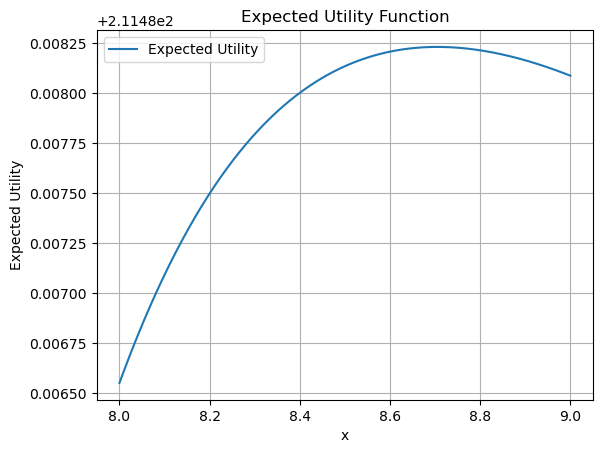

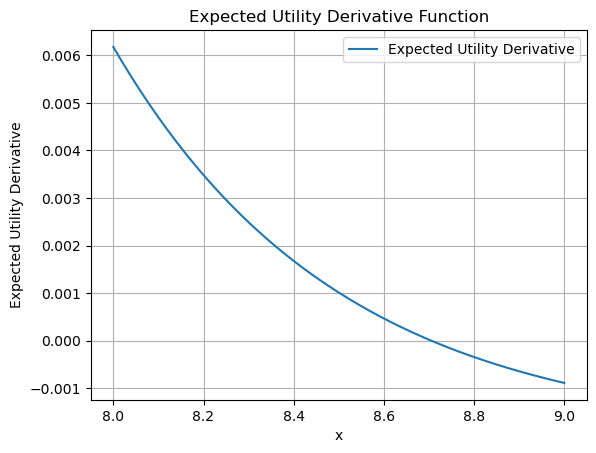

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt


w = 53000

b_1 = 3.8 * 0.9 # multiply Strulik calibration with 0.9 to mimic MMT
b_2 = 0.6506060175382475
b_3 = 0.0337

psi = 2.8
eta = 2.8

D_0 = 0.036
u_c = 0.5 # utility curvature
kappa = 2
chi = 3.5

epsilon = np.array([0, 5])
p = np.array([0.9, 0.1])

d_series = [D_0]

while d_series[-1] < 0.55:
    d_series.append(d_series[-1]*(1+b_3))
    
m_series = [b_1 * (d ** psi) for d in d_series]
m_series_MMT = [m*0.9 for m in m_series]

d = d_series[60]

def utility(c):
    return c**u_c

def utility_dx(c):
    return u_c * c**(u_c-1)

def u_exp(x):
    
    u_term = utility(w - x)
    
    sum_term = np.sum((1 - b_2 * d**eta * np.exp(-kappa * x) * epsilon**chi) * p)
    result = u_term.flatten() * ((sum_term) ** 365 - b_1 * d**psi)
    
    return result

def u_exp_neg(x):
    return -u_exp(x)

# Generate x values
x_values = np.linspace(8, 9, 1000)  # 1000 points from 6 to 7
y = [u_exp(x) for x in x_values]


# Plot the function
plt.plot(x_values, y, label="Expected Utility")
plt.xlabel("x")
plt.ylabel("Expected Utility")
plt.title("Expected Utility Function")
plt.legend()
plt.grid(True)
plt.show()



def u_exp_dx(x):
    u_term = utility(w - x)
    
    # Compute the summation term with correct broadcasting
    sum_term = np.sum((1 - b_2 * d**eta * np.exp(-kappa * x) * epsilon**chi) * p)
    
    # Compute the derivative of u(w-x)
    du_dx = -utility_dx(w - x)
    
    # Compute the derivative of the first term
    inner_derivative = np.sum(kappa * b_2 * d**eta * np.exp(-kappa * x) * epsilon**chi * p)
    
    first_term_derivative = du_dx * ((sum_term) ** 365 - b_1 * d**psi)
    second_term_derivative = u_term * 365 * (sum_term ** 364) * inner_derivative
    
    derivative = first_term_derivative +  second_term_derivative

    return derivative

# Generate x values
y_dx = [u_exp_dx(x) for x in x_values]

plt.plot(x_values, y_dx, label="Expected Utility Derivative")
plt.xlabel("x")
plt.ylabel("Expected Utility Derivative")
plt.title("Expected Utility Derivative Function")
plt.legend()
plt.grid(True)
plt.show()



The following code checks that both functions lead to the same optimal quantity of x. One approach is maximizing the expected utility while the other appraoch finds the root of the derivative:

In [9]:
result = opt.minimize_scalar(u_exp_neg, bounds=(0, w), method="bounded")
print(result)
print("------------")
result_d = opt.fsolve(u_exp_dx, 5)
print(result_d)
print("------------")

 message: Solution found.
 success: True
  status: 0
     fun: [-2.115e+02]
       x: [ 8.705e+00]
     nit: 33
    nfev: 33
------------
[8.70493492]
------------


Currently there is no calibration target set. I approach a first target by setting a relative risk of 1.2 given a shock $\epsilon_{\tau}=7$. I convert annual basic mortality $b_1 d_t^{\psi}$ to daily basic mortality in an approximate way by just dividing by 365, which leads to the following relative risk (RR) equation:

$ 1.2 = \frac{b_1}{365} d^{\psi} + b_2 d^{\eta} e^{-\kappa x} 7^{\chi}$

The following parameters can be chosen for calibration:
- $\kappa$
- $\chi$
- $\eta$
- $b_2$

Further x is not known and should be derived from the maximization problem. To add the calibration target $RR(7)=1.2$, I fix 3 of the 4 parameter unknowns and find a value for the parameter $\kappa$ that solves the following equation system:

$ 1.2 = \frac{b_1}{365} d^{\psi} + b_2 d^{\eta} e^{-\kappa x} 7^{\chi}$

$ 0 = \frac{d}{dx} \left[u(w-x) \right] \left(  \left( \sum_i\left( 1- b_2 d^\eta e^{-\kappa x} \varepsilon_i^\chi \right) p_i \right)^{365} -b_1 d^\psi \right)+ u(w-x)    365 \left( \sum_i\left( 1- b_2 d^\eta e^{-\kappa x} \varepsilon_i^\chi \right) p_i \right)^{364}  \left(  \sum_i \kappa b_2 d^\eta e^{-\kappa x} \varepsilon_i^\chi  p_i   \right)$

with x and $\kappa$ as unknowns and $u(c) = c^{0.5}$. In my code I rearrange the first equation for $\kappa$ and replace $\kappa$ in the second equation. Then I find the root of the second equation to obtain the optimal level of x. Finally I plot the relative risk depending on $\epsilon$ to see if the calibration target if hit under optimal adaptation

[721.39545527]


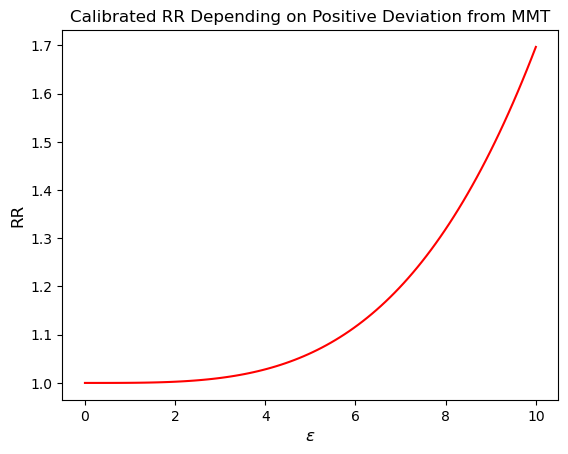

In [10]:
def kappa_fun(x):
    return np.log(0.2 * b_1 / (365 * b_2 * 7**chi)) * (1/(-x))

def u_exp_dx(x):
    u_term = utility(w - x)
    
    # Compute the summation term with correct broadcasting
    sum_term = np.sum((1 - b_2 * d**eta * np.exp(-kappa_fun(x) * x) * epsilon**chi) * p)
    
    # Compute the derivative of u(w-x)
    du_dx = -utility_dx(w - x)
    
    # Compute the derivative of the first term
    inner_derivative = np.sum(kappa_fun(x) * b_2 * d**eta * np.exp(-kappa_fun(x) * x) * epsilon**chi * p)
    
    first_term_derivative = du_dx * ((sum_term) ** 365 - b_1 * d**psi)
    second_term_derivative = u_term * 365 * (sum_term ** 364) * inner_derivative
    
    derivative = first_term_derivative +  second_term_derivative

    return derivative

result_cal = opt.fsolve(u_exp_dx, 5)
print(result_cal)

x_opt = result_cal[0]
kappa = kappa_fun(x_opt)

def RR(T):
    return 1 + 365*b_2/b_1 * d**(eta-psi) * np.exp(-x_opt*kappa) * (T)**chi

T_values = np.linspace(0, 10, 100)  # 500 points for a smooth curve
RR_values = RR(T_values)  # Evaluate the function for all T values


# Plot the function
plt.title("Calibrated RR Depending on Positive Deviation from MMT")
plt.xlabel("$\epsilon$", fontsize=12)
plt.ylabel("RR", fontsize=12)
plt.plot(T_values, RR_values, color='red')
plt.show()


The optimal value of x is 721.39 given an income level of w = 53,000. 